In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras import optimizers

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from warnings import filterwarnings
filterwarnings("ignore")

## Function Definitions

In [142]:
# Print amount of nulls per column
def null_summary(df): 
        for col in df.columns: 
            null_count = df[col].isnull().sum()
            if null_count > 0: 
                print(f"'{col}' : ", null_count, "nulls")


# clean and enumerate credit ratings
def clean_credit_col(df): 
    if(df["CreditRating"].dtypes == "object"): 
        df["CreditRating"] = df["CreditRating"].str[0].astype(int)


# delete negatives from cols that should have only positive ints
def remove_negatives(df, columns_to_exclude=[]):
    df_copy = df.copy()
    if columns_to_exclude:
        df_copy = df_copy.drop(columns=columns_to_exclude)

    df_copy[df_copy < 0] = None 
    df_copy.dropna(inplace=True)
    return df_copy


# Check all customer IDs are unique
def uniqueID_check(df): 
    if (df["CustomerID"].value_counts().sum() == df.shape[0]): 
        print("Customer IDs are unique")

## Plotting Function Definitions

In [357]:
# Plot feature importance (random forest)
def plot_feature_importance_rf(df, rf_model): 
    importances_rf = rf_model.feature_importances_
    feature_labels = df.columns
    indices = np.argsort(-(importances_rf))

    plt.figure(figsize = (14, 4))
    plt.title("Random Forest: Feature Importance")
    plt.bar(range(len(feature_labels)), 
        importances_rf[indices], 
        align = "center")
    plt.xticks(range(len(feature_labels)), 
           feature_labels[indices], 
           rotation = 90)
    plt.tight_layout()
    plt.show()


def plot_conf_matrix(y_test, y_pred): 
    conf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    labels = [f"{v1}:\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot = labels, linewidths= 0.7, fmt = "", cmap = "flare", annot_kws= {"size": "medium"})
    print(classification_report(y_test, y_pred))


def plot_sums_by_churn_probability(df, var_to_group, var_to_sum, num_intervals):
    df["Interval"] = pd.cut(df[var_to_group], bins=num_intervals, labels=False)
    percentile_ranges = pd.qcut(df[var_to_group], num_intervals, labels=False, retbins=True)[1]
    sums_by_interval = df.groupby('Interval')[var_to_sum].sum().reset_index()

    plt.figure(figsize=(9, 5))
    plt.bar(sums_by_interval["Interval"], sums_by_interval[var_to_sum], width=0.7)
    plt.xlabel("Predicted Probability to Churn")
    plt.ylabel(f"Total {var_to_sum}")
    plt.title(f"Total {var_to_sum} by {var_to_group}")
    plt.xticks(range(num_intervals), [f"{percentile_ranges[i+1] * 100:.0f}%" for i in range(num_intervals)])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    plt.grid(axis="y", alpha = 0.7)
    plt.show()


def plot_sums_by_threshold(df, thresholds, var_to_group, var_to_sum):
    sums = []
    for num in thresholds:
        sum_of_var = df.loc[df[var_to_group] > num, var_to_sum].sum()
        sums.append(sum_of_var)
    sorted_thresholds, sorted_sums = zip(*sorted(zip(thresholds, sums)))

    plt.figure(figsize=(9, 5))
    plt.bar(range(len(sorted_thresholds)), sorted_sums, width = 0.8)
    plt.xlabel("Predicted Churn Thresholds")
    plt.ylabel(f"Total {var_to_sum}")
    plt.title(f"Total {var_to_sum} for Thresholds of {var_to_group}")
    plt.xticks(np.arange(len(sorted_thresholds)), [f'{num * 100:.0f}%' for num in sorted_thresholds])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))
    plt.show()


In [144]:
df = pd.read_csv("https://raw.githubusercontent.com/atbalazs/Telecom_Churn_Analysis_and_Forecast/main/cell2cell_data/cell2cell_dataset.csv")
df_copy = df.copy()
df.describe()

,CustomerID,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating
count,7.104700e+04,70831.000000,70831.000000,70831.000000,70831.000000,70831.000000,70831.000000,70545.000000,70545.000000,71047.000000,...,71046.000000,71046.000000,71046.000000,69803.000000,69803.000000,71047.000000,71047.000000,71047.000000,71047.000000,71047.000000
mean,3.201948e+06,58.852853,525.726250,46.862899,0.894817,40.087730,1.222315,-10.845304,-1.204730,6.009567,...,1.808617,1.561791,380.265631,31.375113,21.157715,0.037004,0.017918,0.050854,4.334229,0.053162
std,1.167965e+05,44.243566,530.136184,23.915000,2.197577,96.349599,9.081089,255.314034,38.770236,9.006656,...,1.336120,0.908280,254.294692,22.082195,23.917586,0.205823,0.141485,0.290444,3.137063,0.374988
min,3.000002e+06,-6.170000,0.000000,-11.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.700000,0.000000,...,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.100576e+06,33.640000,158.000000,30.000000,0.000000,0.000000,0.000000,-83.000000,-7.100000,0.700000,...,1.000000,1.000000,204.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.201478e+06,48.530000,366.000000,45.000000,0.250000,2.000000,0.000000,-5.000000,-0.300000,3.000000,...,1.000000,1.000000,330.000000,36.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
75%,3.304918e+06,71.030000,722.000000,60.000000,0.990000,41.000000,0.300000,66.000000,1.600000,7.700000,...,2.000000,2.000000,515.000000,48.000000,42.000000,0.000000,0.000000,0.000000,7.000000,0.000000
max,3.399994e+06,1223.380000,7668.000000,400.000000,159.390000,4321.000000,1112.400000,5192.000000,2483.500000,221.700000,...,28.000000,16.000000,1823.000000,99.000000,99.000000,4.000000,4.000000,35.000000,9.000000,25.000000


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71047 entries, 0 to 71046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 71047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             70831 non-null  float64
 3   MonthlyMinutes             70831 non-null  float64
 4   TotalRecurringCharge       70831 non-null  float64
 5   DirectorAssistedCalls      70831 non-null  float64
 6   OverageMinutes             70831 non-null  float64
 7   RoamingCalls               70831 non-null  float64
 8   PercChangeMinutes          70545 non-null  float64
 9   PercChangeRevenues         70545 non-null  float64
 10  DroppedCalls               71047 non-null  float64
 11  BlockedCalls               71047 non-null  float64
 12  UnansweredCalls            71047 non-null  float64
 13  CustomerCareCalls          71047 non-null  flo

In [146]:
# checking nulls - 20,000 rows without label - fewer than 2% of nontarget rows with null, dropping all null for simplicity
null_summary(df)
print("Rows before drop all null: ", df.shape[0])
print("Rows after drop all null: ", df.dropna().shape[0])

'Churn' :  20000 nulls
'MonthlyRevenue' :  216 nulls
'MonthlyMinutes' :  216 nulls
'TotalRecurringCharge' :  216 nulls
'DirectorAssistedCalls' :  216 nulls
'OverageMinutes' :  216 nulls
'RoamingCalls' :  216 nulls
'PercChangeMinutes' :  502 nulls
'PercChangeRevenues' :  502 nulls
'ServiceArea' :  28 nulls
'Handsets' :  1 nulls
'HandsetModels' :  1 nulls
'CurrentEquipmentDays' :  1 nulls
'AgeHH1' :  1244 nulls
'AgeHH2' :  1244 nulls
Rows before drop all null:  71047
Rows after drop all null:  49752


In [147]:
df.dropna(inplace = True)

## Type conversion
df["HandsetModels"] = df["HandsetModels"].astype("object")
df["Handsets"] = df["Handsets"].astype(int)

for col in df.columns: 
        if df[col].dtype == "object": 
                print(df[col].value_counts())

In [149]:
clean_credit_col(df)
df.drop(["HandsetPrice", "NotNewCellphoneUser"], axis = 1, inplace = True)

## Data Visualization

<Axes: >

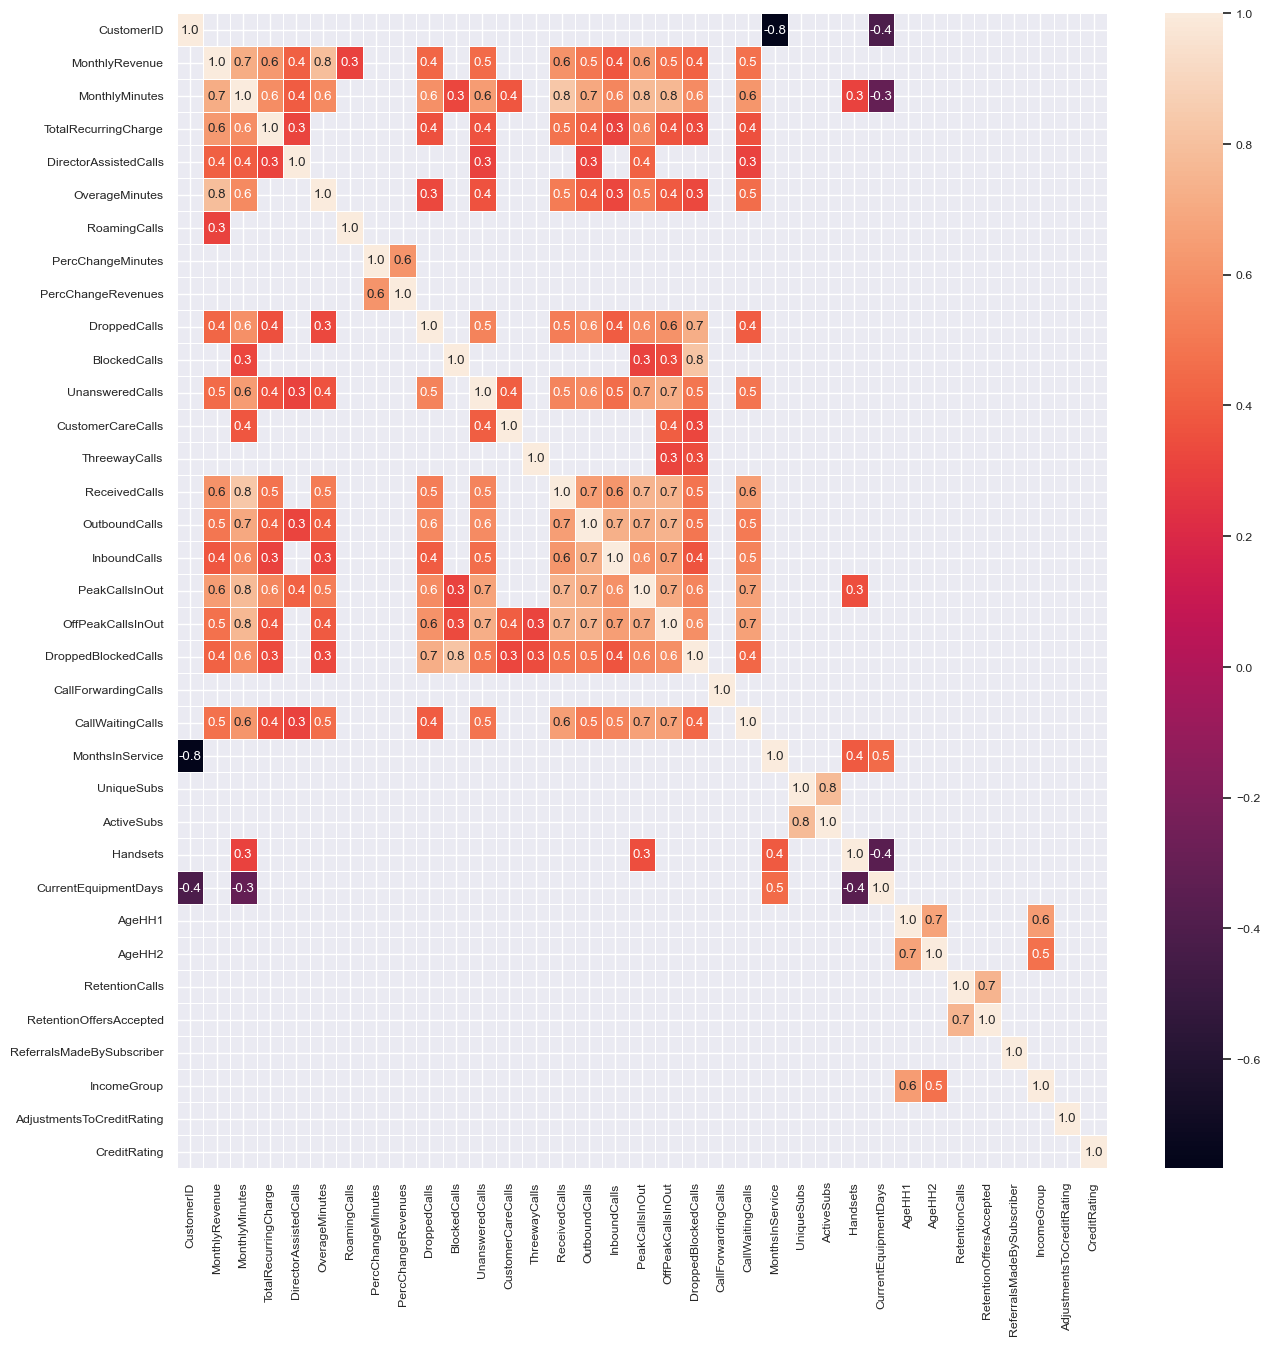

In [150]:
# Heatmap (corr > 0.3 || corr < -0.3)
sns.set_style("dark")
sns.set(font_scale = 0.8)
f, ax = plt.subplots(figsize= (15, 15))
sns.heatmap(df.select_dtypes(include = "number").corr(), annot = True, fmt = ".1f", linewidths= 0.5, mask = df.select_dtypes(include = "number").corr().abs() < 0.3)

## Data Pre-Processing

In [152]:
# Check data balancing
df["Churn"].value_counts()

df_numerical = df.select_dtypes(include = "number")
df_categorical = df.select_dtypes(exclude = "number")

# Copying then dropping customerID as feature
customerIDs = df["CustomerID"]
df.drop("CustomerID", axis = 1, inplace = True)

In [153]:
# Encode churn values: 
churn_mapping = {"Yes": 1, "No": 0}
df["Churn"] = df["Churn"].map(churn_mapping)

# Label encoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df[df_categorical.columns.tolist()] = df[df_categorical.columns.tolist()].apply(LabelEncoder().fit_transform)

# Check for all cols being numeric
print((df.dtypes == "object").any())

False


In [201]:
X = df.drop("Churn", axis = 1)
y = df["Churn"]

# chi2 feature selection
cols_with_neg = ["PercChangeMinutes", "PercChangeRevenues"]
df_pos = df.drop(columns = cols_with_neg)
df_pos = remove_negatives(df, cols_with_neg)

X_pos = df_pos.drop("Churn", axis = 1)
y_pos = df_pos["Churn"]

percent_feats_to_drop = 20
feature_selection_chi2 = SelectKBest(score_func = chi2, k = int(X.shape[1] * (1 - (percent_feats_to_drop/100))))

chi2_features = feature_selection_chi2.fit(X_pos, y_pos)
chi2_feature_names = chi2_features.get_feature_names_out()
selected_feature_names = np.concatenate((chi2_feature_names, cols_with_neg))

X = X[selected_feature_names]

print(X_pos.shape, y_pos.shape)
print(X.shape, y.shape)

(49673, 52) (49673,)
(49752, 45) (49752,)


In [203]:
# Train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, customer_ids_train, customer_ids_test = train_test_split(
    X, y, customerIDs, test_size=0.2, random_state=42)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Upsample with random oversampling
from random import Random
from imblearn.over_sampling import RandomOverSampler
rand_oversampler = RandomOverSampler(random_state = 1)
X_train, y_train = rand_oversampler.fit_resample(X_train, y_train)

# Check resample balancing
np.unique(y_train, return_counts = True)[1]

array([28473, 28473])

## Simple Logistic Regression Model

In [159]:
lr_grid = {
    "C": np.logspace(-4, 4, 50), 
    "penalty": ["l1","l2"]
    }

clf_GS = GridSearchCV(LogisticRegression(), 
                      param_grid = lr_grid,
                      verbose = 1, 
                      scoring = "accuracy"
                      )

clf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-0...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

              precision    recall  f1-score   support

           0       0.77      0.59      0.67     10652
           1       0.36      0.57      0.44      4274

    accuracy                           0.59     14926
   macro avg       0.57      0.58      0.56     14926
weighted avg       0.66      0.59      0.61     14926



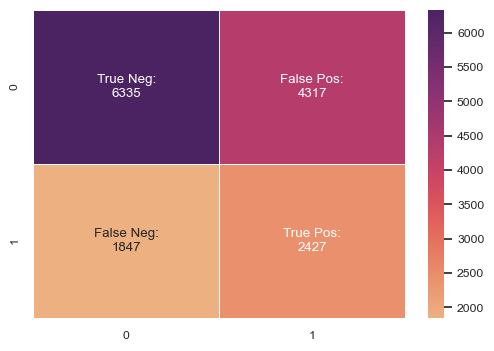

In [160]:
lr_params_optimized = clf_GS.best_params_

lr = LogisticRegression(**lr_params_optimized)
clf_lr = lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

plot_conf_matrix(y_test, y_pred_lr)

## Random Forest Model

In [188]:
rf_params = { 
    "bootstrap": [True, False],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [50, 100, 200, 500, 750, 1000]}

rs_model_rf = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                                 param_distributions = rf_params, 
                                 n_iter = 50, 
                                 cv = 3, 
                                 verbose = 3,
                                 random_state = 1)

rs_model_rf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.723 total time= 1.2min
[CV 2/3] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.719 total time= 1.2min
[CV 3/3] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.722 total time= 1.2min
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.721 total time=   8.7s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.720 total time=   8.7s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.720 total time=   8.7s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=750;, score=0.720 total time=

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 500, 750,
                                                         1000]},
                   random_state=1, verbose=3)

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      7034
           1       0.59      0.15      0.24      2917

    accuracy                           0.72      9951
   macro avg       0.66      0.55      0.53      9951
weighted avg       0.69      0.72      0.66      9951



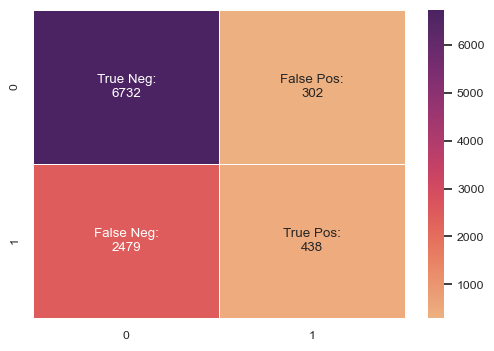

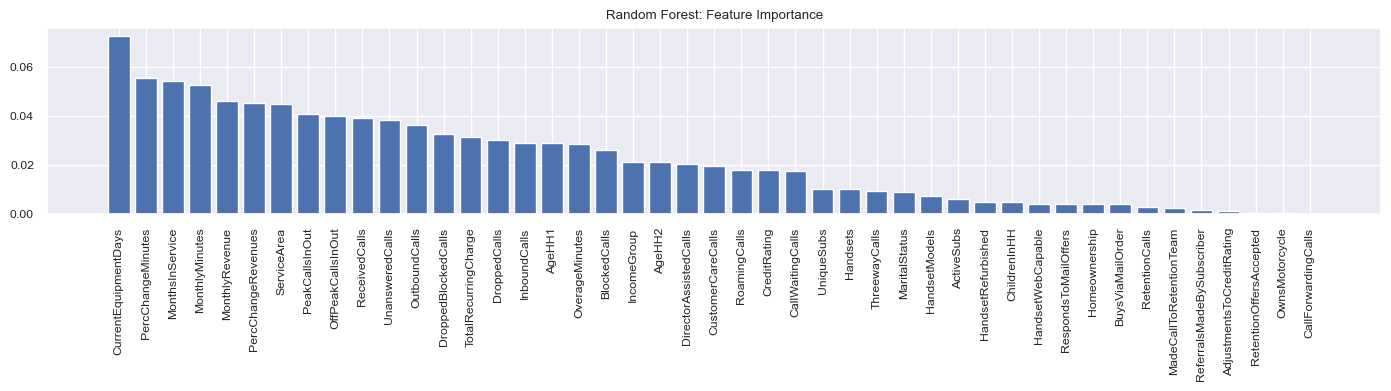

In [324]:
rf_best_params = rs_model_rf.best_params_

rf = RandomForestClassifier(**rf_best_params)
clf_rf = rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

plot_conf_matrix(y_test, y_pred_rf)
plot_feature_importance_rf(X, clf_rf)

## XGBoost Model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.6, 'min_child_weight': 0.5, 'max_depth': 9, 'gamma': 0.5, 'eta': 0.7, 'colsample_bytree': 0.8}
0.8257493462080063
              precision    recall  f1-score   support

           0       0.75      0.79      0.77     10652
           1       0.39      0.34      0.36      4274

    accuracy                           0.66     14926
   macro avg       0.57      0.56      0.57     14926
weighted avg       0.65      0.66      0.65     14926



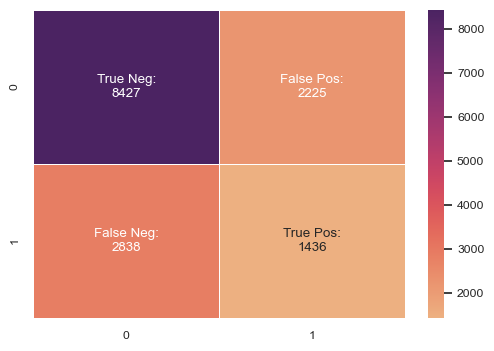

In [166]:
xgb_params = {
    "eta": [0.1, 0.3, 0.5, 0.7],
    "gamma": [0.5, 1, 3, 5],
    "max_depth" : [2, 5, 9],
    "min_child_weight" : [0.5, 1, 5, 10],
    "subsample" : [0.4, 0.6, 0.8], 
    "colsample_bytree" : [0.4, 0.6, 0.8]
}

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

rs_model_xgb = RandomizedSearchCV(estimator = XGBClassifier(), 
                              param_distributions = xgb_params, 
                              n_iter = 10, 
                              scoring = "accuracy", 
                              cv = skf, 
                              verbose = 1)

rs_model_xgb.fit(X_train, y_train)

xgb_params_optimized = rs_model_xgb.best_params_

xgb = XGBClassifier(**xgb_params_optimized)
clf_xgb = xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

plot_conf_matrix(y_test, y_pred_xgb)

## Neural Network Model

In [192]:
tf.random.set_seed(1)
hidden_units = 30
learning_rate = 0.01

nn = keras.Sequential()
nn.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation = "relu"))
nn.add(Dropout(0.5))
nn.add(Dense(hidden_units, activation = "relu"))
nn.add(Dense(hidden_units, activation = "relu"))
nn.add(Dense(1, activation = "sigmoid"))

sgd = optimizers.legacy.SGD(lr = learning_rate)
nn.compile(loss = "binary_crossentropy", optimizer = sgd, metrics = ["accuracy"])

In [193]:
nn.fit(X_train, y_train, epochs = 30, verbose = 1)

Epoch 1/30
  10/1244 [..............................] - ETA: 6s - loss: 1.0476 - accuracy: 0.5063  

2023-09-07 14:16:01.841411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1244/1244 [==============================] - 6s 5ms/step - loss: 0.6226 - accuracy: 0.6899
Epoch 2/30
1244/1244 [==============================] - 6s 5ms/step - loss: 0.5956 - accuracy: 0.7144
Epoch 3/30
1244/1244 [==============================] - 6s 4ms/step - loss: 0.5941 - accuracy: 0.7143
Epoch 4/30
1244/1244 [==============================] - 6s 5ms/step - loss: 0.5929 - accuracy: 0.7144
Epoch 5/30
1244/1244 [==============================] - 6s 4ms/step - loss: 0.5930 - accuracy: 0.7137
Epoch 6/30
1244/1244 [==============================] - 6s 4ms/step - loss: 0.5937 - accuracy: 0.7149
Epoch 7/30
1244/1244 [==============================] - 6s 5ms/step - loss: 0.5937 - accuracy: 0.7136
Epoch 8/30
1244/1244 [==============================] - 6s 4ms/step - loss: 0.5946 - accuracy: 0.7133
Epoch 9/30
1244/1244 [==============================] - 5s 4ms/step - loss: 0.5964 - accuracy: 0.7121
Epoch 10/30
1244/1244 [==============================] - 6s 5ms/step - loss: 0.6013 - accurac

In [194]:
nn.evaluate(X_test, y_test)
nn.summary()

 32/311 [==>...........................] - ETA: 0s - loss: 0.5925 - accuracy: 0.7051

2023-09-07 14:18:49.972788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


311/311 [==============================] - 1s 3ms/step - loss: 0.6093 - accuracy: 0.7027
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 45)                2070      
                                                                 
 dropout_2 (Dropout)         (None, 45)                0         
                                                                 
 dense_9 (Dense)             (None, 30)                1380      
                                                                 
 dense_10 (Dense)            (None, 30)                930       
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 4411 (17.23 KB)
Trainable params: 4411 (17.23 KB)
Non-trainable params: 0 (0.00 Byt

## Identifying Revenue Risk and Highest-Risk Customers

In [325]:
# Selected random forest with tuned hyperparameters due to high recall
predictions_rf = clf_rf.predict_proba(X_test)[:, 1]

churn_pred_by_customer = pd.DataFrame({"CustomerID": customer_ids_test,
                                    "ChurnPred" : predictions_rf})

predicted_test_df = pd.concat([churn_pred_by_customer, 
                              pd.DataFrame(X_test_copy, columns= selected_feature_names)], 
                              axis = 1).sort_values(by = "ChurnPred", ascending = False)

predicted_test_df.head(5)

,CustomerID,ChurnPred,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,DroppedCalls,BlockedCalls,...,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,MadeCallToRetentionTeam,CreditRating,MaritalStatus,PercChangeMinutes,PercChangeRevenues
34513,3275330,0.883389,29.99,0.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0,0,9,0,0,0,2,2,0.0,0.0
41243,3328494,0.876023,10.00,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0,0,6,0,0,0,2,2,0.0,0.0
33113,3263770,0.875733,49.99,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0,0,9,1,0,0,2,2,0.0,0.0
33764,3269078,0.871339,27.05,0.0,36.0,0.0,0.0,0.0,0.0,0.0,...,0,0,5,0,0,0,2,1,0.0,2.9
42264,3336230,0.863607,34.99,0.0,45.0,0.0,0.0,0.0,0.0,0.0,...,0,0,5,0,0,0,3,2,0.0,0.0


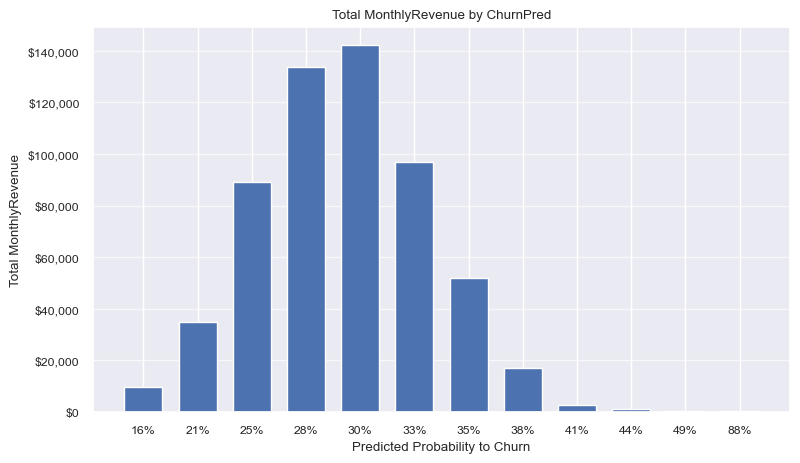

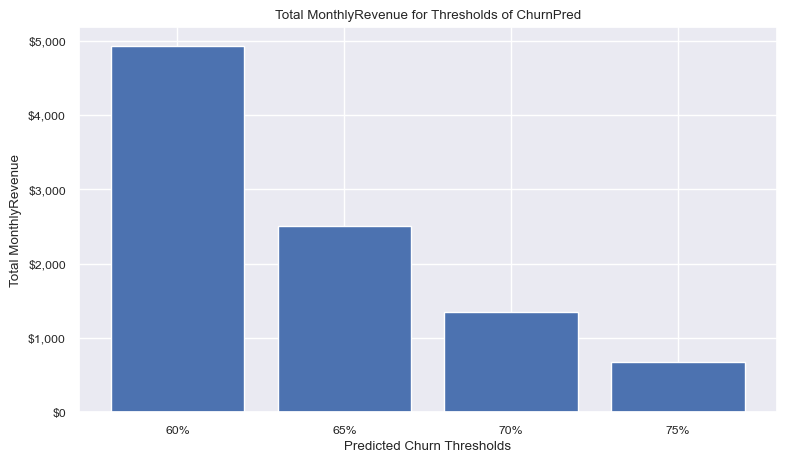

In [358]:
plot_sums_by_churn_probability(predicted_test_df, "ChurnPred", "MonthlyRevenue", 12)
plot_sums_by_threshold(predicted_test_df, [0.75, 0.7, 0.65, 0.6], "ChurnPred", "MonthlyRevenue")

In [373]:
# Displaying CustomerID for customers in 90th percentile of churn probability, sorted by highest risk
highest_risk_customers = pd.DataFrame(predicted_test_df.loc[predicted_test_df["ChurnPred"] >= predicted_test_df["ChurnPred"].quantile(0.9), 
                                                            ["CustomerID", "ChurnPred"]]).sort_values(by = "ChurnPred", ascending = False)

highest_risk_customers

,CustomerID,ChurnPred
34513,3275330,0.883389
41243,3328494,0.876023
33113,3263770,0.875733
33764,3269078,0.871339
42264,3336230,0.863607
...,...,...
7890,3062170,0.480425
28137,3222878,0.480382
5343,3041750,0.480347
41641,3331594,0.480326
